The purpose of this notebook is to understand which group of people respond best to which offer type using machine learning models. Because an offer might be completed without being viewed, we want to fit models seperately to offers that were viewed and offers that were not viewed since the people who completed the offers in the 2 groups might be different.

In addition to demographics features and promo features built in the previous notebook, we will build a few more features that describe the customers' `purchase related behaviors`, including:
<br>**offers_viewed_before:** at the time a person received an offer, how many offers they had seen before?
<br>**offers_completed_before:** at the time a person received an offer, how many offers they had completed before?
<br>**hours_since_last_viewed:** at the time a person received an offer, how many hours have passed since the person viewed the last offer
<br>**cum_amount:** at the time a person received an offer, how much money they had spent?

In the end, we discussed how the models can be used to reduce promo spending. We assume that there's no cost for a promo just to be sent (this might not be true, but since in this project we don't have `promo cost` data we would just assume so). There's no penalty for a sent promo not to be completed. So the way to use predictive models is to predict who will compelte an offer without knowing it and we won't send out promo to those people.

# 1. Load data and packages

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', 500)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

from DataPreparation import DataPreparation
from StarbucksModelNew import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

offer_pipe = pd.read_csv("offer_pipe_for_modeling.csv")
offer_pipe['offer_rank_in_person'] = offer_pipe.groupby('person')['time'].rank()
transcript = pd.read_csv("transcript_cleaned.csv")

# 2. Build features based on customers' activities

**In the previous notebook we have built various features around the customers and the offers.** But we want to consider another aspect of their behaviors --- has a customer taken any offers before the current offer? How many offers they had taken? How many other offers they had seen before?

## 2.1 offers_viewed_before
at the time a person received an offer, how many offers they had seen before?

In [2]:
#at the time a person received an offer, how many offers they had seen before?
offer_pipe_historically_viewed = offer_pipe[['person','offer_id','offer_rank_in_person','time']]\
.merge(offer_pipe[offer_pipe['effectively_viewed']][['person','time']], on="person", suffixes=('_later','_earlier'))

offer_pipe_historically_viewed = offer_pipe_historically_viewed\
                                             [offer_pipe_historically_viewed['time_later'] > offer_pipe_historically_viewed['time_earlier']]

offer_pipe_historically_viewed_groupby = offer_pipe_historically_viewed\
                                                          .groupby(['person','offer_id','offer_rank_in_person'])['time_later'].count()\
                                                          .reset_index()\
                                                          .rename({'time_later':'offers_viewed_before'}, axis=1)

## 2.2 offers_completed_before
at the time a person received an offer, how many offers they had completed before?

In [3]:
#at the time a person received an offer, how many offers they had completed before?
offer_pipe_historically_completed= offer_pipe[['person','offer_id','offer_rank_in_person','time']]\
.merge(offer_pipe[offer_pipe['completed']][['person','time']], on="person", suffixes=('_later','_earlier'))

offer_pipe_historically_completed = offer_pipe_historically_completed\
                                                  [offer_pipe_historically_completed['time_later'] > offer_pipe_historically_completed['time_earlier']]

offer_pipe_historically_completed_groupby = offer_pipe_historically_completed\
                                                                .groupby(['person','offer_id','offer_rank_in_person'])['time_later'].count()\
                                                                .reset_index()\
                                                                .rename({'time_later':'offers_completed_before'}, axis=1)

## 2.3 hours_since_last_viewed
at the time a person received an offer, how many hours have passed since the person viewed the last offer

In [4]:
#at the time a person received an offer, how many hours have passed since the person viewed the last offer
offer_pipe_recent_viewed = offer_pipe_historically_viewed.groupby(['person','offer_id','offer_rank_in_person']).max().reset_index()
offer_pipe_recent_viewed['hours_since_last_viewed'] = offer_pipe_recent_viewed['time_later'] - offer_pipe_recent_viewed['time_earlier']

## 2.4 hours_since_last_completed
at the time a person received an offer, how many hours have passed since the person completed the last offer

In [5]:
#at the time a person received an offer, how many hours have passed since the person completed the last offer
offer_pipe_recent_completed = offer_pipe_historically_completed.groupby(['person','offer_id','offer_rank_in_person']).max().reset_index()
offer_pipe_recent_completed['hours_since_last_completed'] = offer_pipe_recent_completed['time_later'] - offer_pipe_recent_completed['time_earlier']

## 2.5 cum_amount
at the time a person received an offer, how much money they had spent?

In [6]:
#at the time a person received an offer, how much money they had spent?
person_time_money = transcript.groupby(['person','time'])['amount'].sum().reset_index().sort_values(['person','time'])
person_time_money['cum_amount'] = person_time_money.groupby('person')['amount'].cumsum()

> Use these new features to enrich `offer_pipe`.

In [7]:
offer_pipe_new = offer_pipe\
.merge(offer_pipe_historically_viewed_groupby, on=['person','offer_id','offer_rank_in_person'], how="left")\
.merge(offer_pipe_historically_completed_groupby, on=['person','offer_id','offer_rank_in_person'], how="left")\
.merge(offer_pipe_recent_viewed[['person','offer_id','offer_rank_in_person','hours_since_last_viewed']], 
          on=['person','offer_id','offer_rank_in_person'], 
          how="left")\
.merge(offer_pipe_recent_completed[['person','offer_id','offer_rank_in_person','hours_since_last_completed']], 
          on=['person','offer_id','offer_rank_in_person'], 
          how="left")\
.merge(person_time_money[['person','time','cum_amount']], on=['person','time'], how="left")

In [8]:
print(len(offer_pipe))
print(len(offer_pipe[['person','offer_id','offer_rank_in_person']].drop_duplicates()))

61042
61042


In [9]:
offer_pipe_new_by_type = offer_pipe_new.groupby(['offer_type','effectively_viewed','completed']).count()['person']\
                                     .reset_index().set_index(['offer_type','effectively_viewed'])
offer_pipe_new_by_type['percentage'] = offer_pipe_new_by_type.groupby(['offer_type','effectively_viewed'])['person'].apply(lambda x: x/x.sum())

In [10]:
offer_pipe_new_by_type

completed  person  percentage
offer_type effectively_viewed                               
bogo       False                   False    2924    0.391223
           False                    True    4550    0.608777
           True                    False   12074    0.524387
           True                     True   10951    0.475613
discount   False                   False    5783    0.523585
           False                    True    5262    0.476415
           True                    False    7160    0.367217
           True                     True   12338    0.632783

Luckily we haven't faces the situation of imbalanced data yet. The positive rates (rate of completing the offer) all look quite good. There are no extremely small postive rates.

# 3. Train models on different subsets of data to understand how the different features affect customers' behaviors on different offers

We have already developed the modeling pipeline as a class called `StarbucksModel`. In the pipeline we will perform `train_test_split`, `data scaling`, `parameter tuning`, `modeling training and testing` and `exploring feature importance`.

We want to fit 4 models on `bogo` offers that were viewed, `bogo` offers that were not viewed, `discount` offers that were viewed and `discount` offers that were not viewed. We will explore the feature importance matrixes of the 4 models to understand how different features affect different offers.

In [11]:
#candidate parameters for grid search

params = {'learning_rate':[0.1, 0.2, 0.5], 'max_depth':[3,6,9], 'subsample':[0.6, 0.8, 1], 'min_samples_split':[2, 4]}

## 3.1 Buy-one-get-one offers that were not viewed

/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:75: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  2.3min finished


===Model===
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
===Result on Testing set===
{'precision': 0.7928496319663512, 'recall': 0.8285714285714286, 'f1': 0.8103170338527673}


/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)
/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:118: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)


===Important features===
                      features  importance
17                  cum_amount    0.534910
10                      income    0.113466
11                customer_age    0.069932
9                       gender    0.051513
16  hours_since_last_completed    0.050379


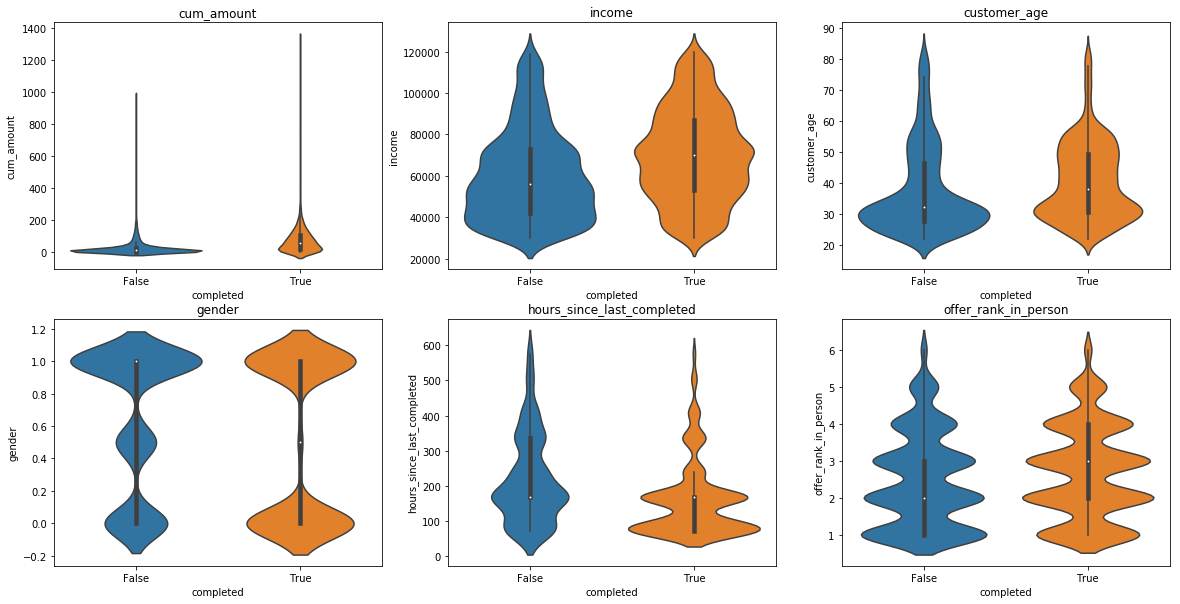

In [12]:
dp = DataPreparation()
sm_bogo1 = StarbucksModel(DataPreparation())
f = sm_bogo1.train_full(offer_pipe_new[(offer_pipe_new['offer_type'] == "bogo") & (~offer_pipe_new['effectively_viewed'])]\
                  .drop(['person', 'offer_id', 'effectively_viewed', 'offer_type'], axis=1), 
                  GradientBoostingClassifier(),
                  params)

> For buy-one-get-one offers that weren't viewed, cumulative purchase amount at the time the customer received the offer, customer's income level and "customer_age" (how long has the customer been with us), hours since the last offer was completed are important factors. Customers who have higher income levels and who have already had some purchases with us are more likely to complete the offer.

## 3.2 Buy-one-get-one offers that were viewed

/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:75: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  6.9min finished


===Model===
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
===Result on Testing set===
{'precision': 0.7776236708275543, 'recall': 0.7676859881332725, 'f1': 0.7726228755167661}


/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)
/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:118: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)


===Important features===
                features  importance
17            cum_amount    0.438326
11          customer_age    0.159085
10                income    0.132510
9                 gender    0.099934
12  offer_rank_in_person    0.041133


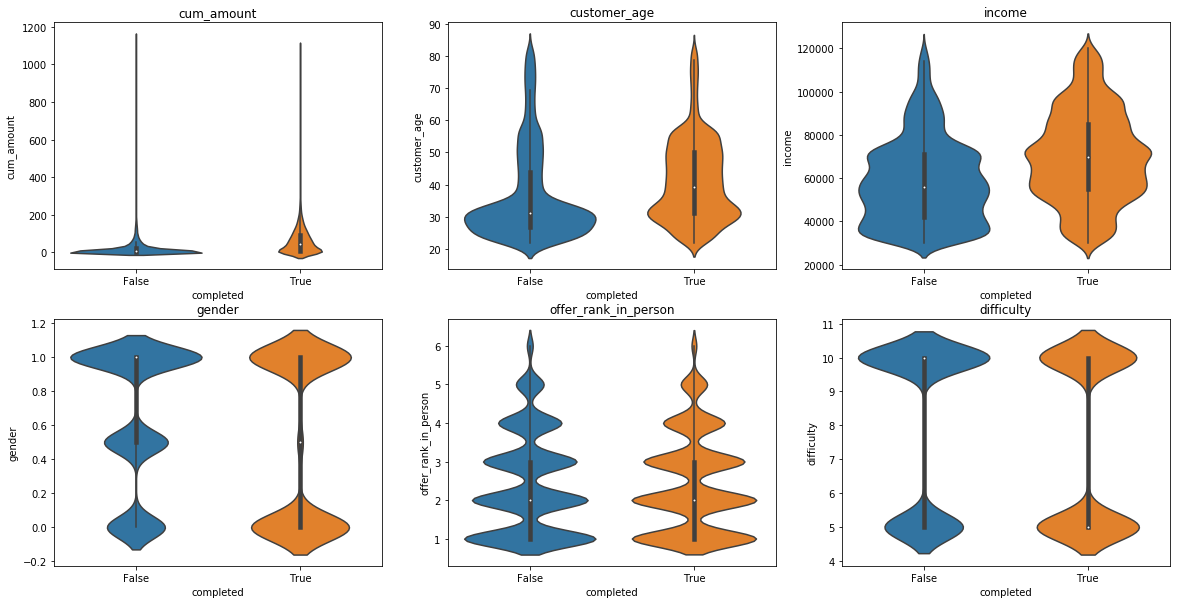

In [13]:
dp = DataPreparation()
sm = StarbucksModel(DataPreparation())
f = sm.train_full(offer_pipe_new[(offer_pipe_new['offer_type'] == "bogo") & (offer_pipe_new['effectively_viewed'])]\
                  .drop(['person', 'offer_id', 'effectively_viewed', 'offer_type'], axis=1), 
                  GradientBoostingClassifier(),
                  params)

> Important features for buy-one-get-one offers that were viewed are similar to the un-viewed group, except that here gender plays a bigger role. Compared to male customers, female customers are more likely to complete the offer when they know about it.

## 3.3 Discount offers that were not viewed

/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:75: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  3.4min finished


===Model===
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.6, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
===Result on Testing set===
{'precision': 0.774582560296846, 'recall': 0.7929724596391263, 'f1': 0.7836696386672922}


/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)
/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:118: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)


===Important features===
        features  importance
17    cum_amount    0.488469
10        income    0.171272
7         social    0.097232
0           time    0.055573
11  customer_age    0.052362


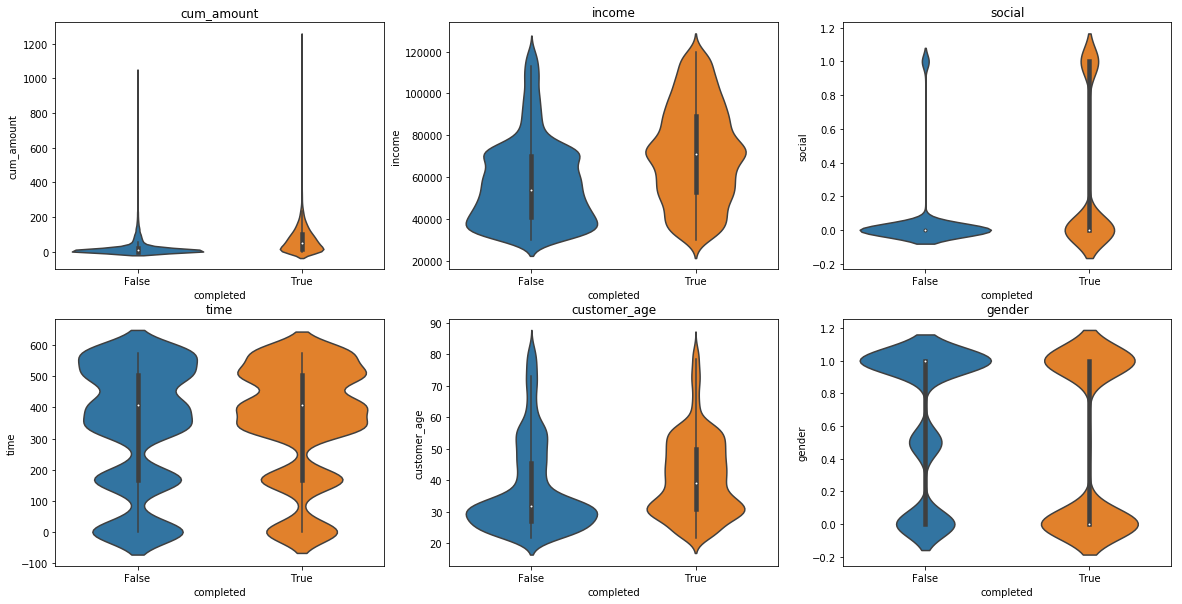

In [14]:
dp = DataPreparation()
sm = StarbucksModel(DataPreparation())
f = sm.train_full(offer_pipe_new[(offer_pipe_new['offer_type'] == "discount") & (~offer_pipe_new['effectively_viewed'])]\
                  .drop(['person', 'offer_id', 'effectively_viewed', 'offer_type'], axis=1), 
                  GradientBoostingClassifier(),
                  params)

In [15]:
offer_pipe[(offer_pipe['social'] == 1) & (offer_pipe['offer_type'] == 'discount')]['offer_id'].unique()

array(['fafdcd668e3743c1bb461111dcafc2a4',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

> For discount offers that weren't viewed, cumulative purchase amount, customer's income level, whether this offer was sent through social channel are important factors. It's interesting to see that offers that were sent through social channels are more likely to be completed (there are 2 such offers)

## 3.3 Discount offers that were viewed

/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:75: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  6.2min finished


===Model===
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
===Result on Testing set===
{'precision': 0.8269841269841269, 'recall': 0.8444084278768234, 'f1': 0.8356054530874099}


/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)
/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:118: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)


===Important features===
                   features  importance
11             customer_age    0.368015
17               cum_amount    0.216363
9                    gender    0.113996
10                   income    0.100259
14  offers_completed_before    0.045147


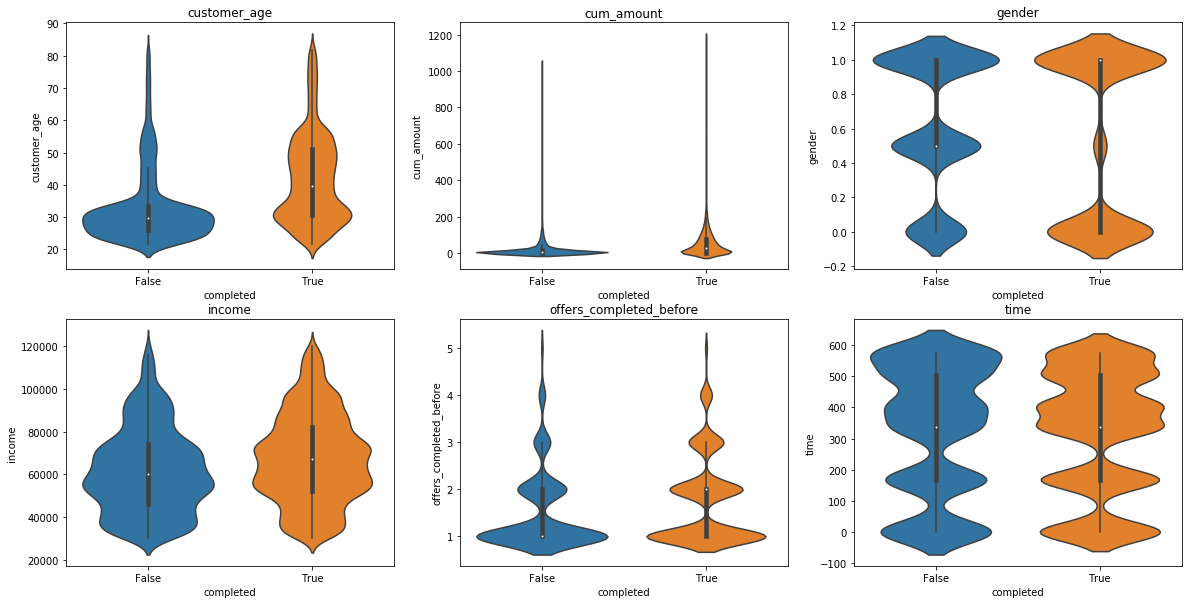

In [16]:
dp = DataPreparation()
sm = StarbucksModel(DataPreparation())
f = sm.train_full(offer_pipe_new[(offer_pipe_new['offer_type'] == "discount") & (offer_pipe_new['effectively_viewed'])]\
                  .drop(['person', 'offer_id', 'effectively_viewed', 'offer_type'], axis=1), 
                  GradientBoostingClassifier(),
                  params)

> For discount offers that were viewed, customer age, cumulative purchase amount, gender, income level and time the offer was sent are important factors. We also see the pattern here that female customers are more likely to complete the offer when they have viewed the offer. It seems that customers who have completed some offers before the new offer are also more likely to complete the offer.

# 4. A senario to use the model...

Since there's no cost for an offer just to be sent --- if the customer doesn't complete the offer, we don't lose any money. One way for us to use the model to improve revenue is to predict who will complete the offer when they don't know about the offer. This might not be a good idea because although we improve revenue in this way, it might hurt our relationship with the customers in the long run. It depends on the marketing strategies and if we are looking to cut the spending on promos, our models can help a lot.

We will train 2 models, one on the bogo offers that were not viewed and another one on the discount offers that were not viewed. The params of the models will be the best parameters we got from the previous section. Assume that we want to determine what offers should be sent for tomorrow. So we plan to use the past data till 10 days before to train the model to make sure that in the training data all offers have expired.

## 4.1 Training the model for bogo offers

In [23]:
def train_a_model(offer_type_name, params):
    dp = DataPreparation()
    sm = StarbucksModel(DataPreparation())
    subset = offer_pipe_new[(offer_pipe_new['offer_type'] == offer_type_name) & \
                                       (~offer_pipe_new['effectively_viewed']) & \
                                       (offer_pipe_new['time'] < offer_pipe_new['time'].max() - 10)]\
                 .drop(['person','offer_id','offer_type','effectively_viewed'], axis=1)
    sm.train_model(subset.drop('completed', axis=1), 
                          subset['completed'], 
                          GradientBoostingClassifier(),
                          params)
    return sm

def auc_plot(y, y_pred, offer_type_name):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - predict completion rates of {} offers that are not viewed'.format(offer_type_name))
    plt.legend(loc="lower right")
    plt.show()

In [18]:
sm_bogo = train_a_model('bogo', {'subsample': [0.8]})

/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:75: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


#### Test it on the data for the last day (bogo offers that were not viewed)

In [19]:
subset = offer_pipe_new[(offer_pipe_new['offer_type'] == 'bogo')&(~offer_pipe['effectively_viewed'])&(offer_pipe_new['time']  == offer_pipe_new['time'].max())]\
             .drop(['person','offer_id','offer_type','effectively_viewed'], axis=1)

subset['predicted_prob'] = sm_bogo.predict(subset.drop('completed', axis=1))

/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:133: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  test_data = self.scaler.transform(test_data)


Text(0.5, 1.0, 'Offer completions and the predicted completion probabilities')

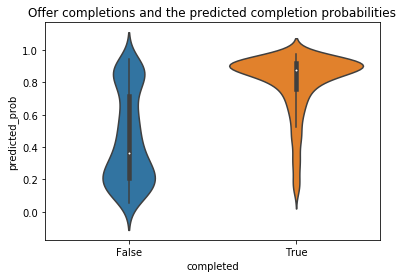

In [20]:
sns.violinplot(x="completed", y='predicted_prob', data=subset)
plt.title("Offer completions and the predicted completion probabilities")

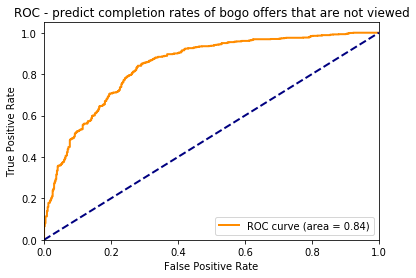

In [24]:
auc_plot(subset['completed'], subset['predicted_prob'], 'bogo')

> Our model reaches a AUC score of 0.84

## 4.2 Training the model for discount offers

In [30]:
sm_discount = train_a_model('discount', {'subsample': [0.8]})

/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:75: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = self.scaler.transform(X)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished


In [31]:
subset = offer_pipe_new[(offer_pipe_new['offer_type'] == 'discount') &(~offer_pipe_new['effectively_viewed'])&(offer_pipe_new['time']  == offer_pipe_new['time'].max())]\
             .drop(['person','offer_id','offer_type','effectively_viewed'], axis=1)

subset['predicted_prob'] = sm_discount.predict(subset.drop('completed', axis=1))

/Users/tianyiwang/Desktop/Udacity/Udacity_Project_9/StarbucksModelNew.py:133: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  test_data = self.scaler.transform(test_data)


Text(0.5, 1.0, 'Offer completions and the predicted completion probabilities')

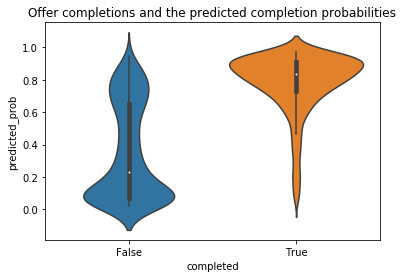

In [32]:
sns.violinplot(x="completed", y='predicted_prob', data=subset)
plt.title("Offer completions and the predicted completion probabilities")

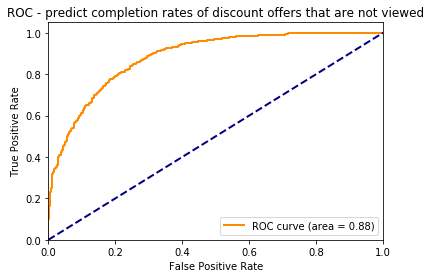

In [34]:
auc_plot(subset['completed'], subset['predicted_prob'], 'discount')

> Our model reaches a AUC score of 0.88